# First attempt: PyPDF2

In [ ]:
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 KB 13.9 MB/s eta 0:00:00


In [ ]:
# !wget https://archive.org/stream/corpvs-inscriptionvm-etrvscarvm_20221021/CORPVS%20INSCRIPTIONVM%20ETRVSCARVM_djvu.txt -O "CORPVS INSCRIPTIONVM ETRVSCARVM.txt"

In [ ]:
from PyPDF2 import PdfFileReader
import re
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from typing import Optional, List
from queue import PriorityQueue
from tqdm.notebook import tqdm
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
data = "/gdrive/MyDrive/CORPVS INSCRIPTIONVM ETRVSCARVM.pdf"
data_txt = "/gdrive/MyDrive/CORPVS INSCRIPTIONVM ETRVSCARVM.txt"
data_pdf = "/gdrive/MyDrive/CIEP.txt"
data_export = "/gdrive/MyDrive/CIEP.csv"

In [ ]:
def load_text(path):
    out = []
    with open(path, "r") as f:
        out = f.readlines()
    out = map(lambda x: x.strip(), out)
    return [i for i in out if i != ""]

In [ ]:
def get_data(lines, r):
    return [i for i in lines if r.match(i)]

## Extract PDF text

In [ ]:
pdf = PdfFileReader(data)

In [ ]:
def extract(pdf):
    out = [None for i in range(len(pdf.pages))]
    for i, page in enumerate(tqdm(pdf.pages)):
        out[i] = page.extract_text().split("\n")
    out = [line.strip() for page in out for line in page if page is not None and line != ""]
    out = [i for i in out if i != ""]
    return out

In [ ]:
def save_text_file(lines, name):
    with open(name, "wt") as f:
        for line in lines:
            f.write(line)
            f.write("\n")

In [ ]:
text = extract(pdf)
print("Lines:", len(text))

100%|██████████| 20164/20164 [19:44<00:00, 17.03it/s]


Lines: 1043206


In [ ]:
save_text_file(text, data_pdf)

In [ ]:
with open(data_pdf, "rt") as f:
    tmp = f.readlines()
    print(len(tmp))

952223


## Extract inscriptions from PDF and TXT with REGEX

Notation:
* T: transcript / inscriptions
* C: reconstructions
* A: traslation

In [ ]:
r = re.compile("(INSCRIPTIO NVMERO \d*.)|(^T\d)|(^C\d)|(^A\d)")

In [ ]:
pdf_text = load_text(data_pdf)
txt_text = load_text(data_txt)

In [ ]:
pdf_extract = get_data(pdf_text, r)
txt_extract = get_data(txt_text, r)
print("PDF - Lines:", len(pdf_extract))
print("TXT - Lines:", len(txt_extract))
print("PDF - Inscriptions:", len([i for i in pdf_extract if i.strip().startswith("INS")]))
print("TXT - Inscriptions:", len([i for i in txt_extract if i.strip().startswith("INS")]))
print("PDF - Transcriptions:", len([i for i in pdf_extract if i.strip().startswith("T")]))
print("TXT - Transcriptions:", len([i for i in txt_extract if i.strip().startswith("T")]))

PDF - Lines: 92036
TXT - Lines: 41874
PDF - Inscriptions: 21506
TXT - Inscriptions: 21176
PDF - Transcriptions: 35264
TXT - Transcriptions: 11191


## Extract by finding the inscription numbers

**Outdated**

In [ ]:
# r = re.compile("Inscription Number")

In [ ]:
# pdf_text = load_text(data_pdf)
# txt_text = load_text(data_txt)

In [ ]:
# pdf_extract = get_data(pdf_text, r)
# txt_extract = get_data(txt_text, r)
# print("PDF - Inscriptsions:", len(pdf_extract))
# print("TXT - Inscriptsions:", len(txt_extract))
# print("PDF - Unique Inscriptions:", len(set(pdf_extract)))
# print("TXT - Unique Inscriptions:", len(set(txt_extract)))

PDF - Inscriptsions: 92036
TXT - Inscriptsions: 41874
PDF - Unique Inscriptions: 73242
TXT - Unique Inscriptions: 38340


In [ ]:
# r = re.compile("(T\d)|(C\d)|(A\d)|(Inscription Number)")

In [ ]:
# pdf_extract = get_data(pdf_text, r)
# txt_extract = get_data(txt_text, r)
# print("PDF - Matching Lines:", len(pdf_extract))
# print("TXT - Matching Lines", len(txt_extract))

PDF - Matching Lines: 70886
TXT - Matching Lines 33559


## Group inscriptions

In [ ]:
def count_lines(lines, head_re, chunk_re):
    head = None
    count = 0
    headless = 0
    out = []
    chunks = []
    for line in lines:
        if head_re.match(line):
            if head is not None:
                out.append((head, count, chunks))
            head = line
            count = 0
            chunks = []
        elif chunk_re.match(line):
            if head is not None: 
                count += 1
                chunks.append(line)
        else:
            headless += 1
    return out, headless

In [ ]:
pdf_group, pdf_headless = count_lines(pdf_extract, re.compile("^INSCRIPTIO NVMERO \d*."), re.compile("(^T\d)|(^C\d)|(^A\d)"))
print("Headless:", pdf_headless)

Headless: 0


In [ ]:
df = pd.DataFrame(pdf_group)
df.columns = ["Inscription str", "Lines", "Raw"]
df

,Inscription str,Lines,Raw
0,INSCRIPTIO NVMERO 8548 (POST,0,[]
1,INSCRIPTIO NVMERO 8585 ORIGINIS,0,[]
2,INSCRIPTIO NVMERO 8586 (POST,0,[]
3,INSCRIPTIO NVMERO 8600 regione del,0,[]
4,INSCRIPTIO NVMERO 17321. Inscription Number 17...,5,"[T1A (MERCVRIVS AD DEXTRVM, T1B (GRYPHVS AD DE..."
...,...,...,...
21500,INSCRIPTIO NVMERO 21994. Inscription Number 21...,2,"[T1 -, C1 A 1]"
21501,INSCRIPTIO NVMERO 21995. Inscription Number 21...,2,"[T1 -, C1 A 1]"
21502,INSCRIPTIO NVMERO 21996. Inscription Number 21...,2,"[T1 -, C1 A 1]"
21503,INSCRIPTIO NVMERO 21997. Inscription Number 21...,2,"[T1 -, C1 A 1]"


In [ ]:
print("Longest chunk:", df["Lines"].max())
print("Avg. chunk:", df["Lines"].mean())
print("Inscriptions with text:", len(df[df["Lines"] != 0]))

Longest chunk: 1798
Avg. chunk: 3.2796093931643804
Inscriptions with text: 21160


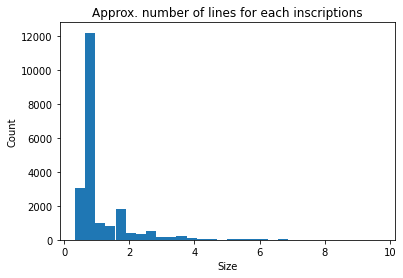

In [ ]:
plt.hist(df[(df["Lines"] < 30) & (df["Lines"] > 0)]["Lines"] / 3, bins=30)
# plt.hist(df[1] / 3, bins=30)
plt.title("Approx. number of lines for each inscriptions")
plt.ylabel("Count")
plt.xlabel("Size")
plt.show()

In [ ]:
# df.iloc[16734]["Raw"]

In [ ]:
df = df[df["Lines"] != 0]
print("Non-empty:", len(df))

Non-empty: 21160


In [ ]:
ciep_id_re = re.compile("[0-9]+")
def get_ciep_id(inscript: str) -> Optional[str]:
    match = ciep_id_re.search(inscript)
    if match is not None:
        return match.group()

space_re = re.compile(" +")
def norm_space(lines: List) -> List[str]:
    return [re.subn(space_re, " ", i)[0].strip() for i in lines]

In [ ]:
df["CIEP"] = df["Inscription str"].apply(get_ciep_id)
df["Raw"] = df["Raw"].apply(norm_space)
df

<ipython-input-19-62744fbac195>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CIEP"] = df["Inscription str"].apply(get_ciep_id)
<ipython-input-19-62744fbac195>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Raw"] = df["Raw"].apply(norm_space)


,Inscription str,Lines,Raw,CIEP
4,INSCRIPTIO NVMERO 17321. Inscription Number 17...,5,"[T1A (MERCVRIVS AD DEXTRVM, T1B (GRYPHVS AD DE...",17321
5,INSCRIPTIO NVMERO 17322. Inscription Number 17...,5,"[T1A (MERCVRIVS AD DEXTRVM, T1B (AQVILLA FVLME...",17322
6,INSCRIPTIO NVMERO 15699. Inscription Number 15...,7,"[T1 VISMATIAE, T2 SEX • FIL, T3 PAETINAE, C1 V...",15699
7,INSCRIPTIO NVMERO 15700. Inscription Number 15...,11,"[T1 ------ DIL • M------------, T2 -------- FI...",15700
8,INSCRIPTIO NVMERO 16617. Inscription Number 16...,54,"[T1A RUVI • RUN • PR, T2A FERINTIES • IS, T3A ...",16617
...,...,...,...,...
21500,INSCRIPTIO NVMERO 21994. Inscription Number 21...,2,"[T1 -, C1 A 1]",21994
21501,INSCRIPTIO NVMERO 21995. Inscription Number 21...,2,"[T1 -, C1 A 1]",21995
21502,INSCRIPTIO NVMERO 21996. Inscription Number 21...,2,"[T1 -, C1 A 1]",21996
21503,INSCRIPTIO NVMERO 21997. Inscription Number 21...,2,"[T1 -, C1 A 1]",21997


In [ ]:
# key_re = re.compile("[TCA] [0-9]+[a-zA-Z]*")
# def get_T(lines: )

In [ ]:
T_re = re.compile("T *[0-9]+[a-zA-Z]*")
not_T_re = re.compile("[CA] *[0-9]+[a-zA-Z]*")
C_re = re.compile("C *[0-9]+[a-zA-Z]*")
not_C_re = re.compile("[TA] *[0-9]+[a-zA-Z]*")
A_re = re.compile("A *[0-9]+[a-zA-Z]*")
not_A_re = re.compile("[CT] *[0-9]+[a-zA-Z]*")

key = re.compile("[0-9]+[a-zA-Z]?")
# TODO fix extraction of C and A
def get_TCA(lines):
    text = " ".join(lines)
    
    T = list(T_re.finditer(text))
    C = list(C_re.finditer(text))
    A = list(A_re.finditer(text))
    
    # Queue: (start, end, key, type)
    q = PriorityQueue()

    for t in T:
        q.put((t.start(), t.end(), key.findall(t.group())[0], "t"))
    for c in C:
        q.put((c.start(), c.end(), key.findall(c.group())[0], "c"))
    for a in A:
        q.put((a.start(), a.end(), key.findall(a.group())[0], "a"))
    
    Ts = []
    Cs = []
    As = []
    t_keys = []
    c_keys = []
    a_keys = []

    map_ = {
        "t": (Ts, t_keys),
        "c": (Cs, c_keys),
        "a": (As, a_keys),
    }
    if not q.empty():
        start, end, k, t = q.get()

        while(not q.empty()):
            s, keys = map_[t]
            # Add the key
            keys.append(k)

            # Annd the text
            from_ = end + 1
            start, end, k, t = q.get()
            to_ = start
            s.append(text[from_:to_])     
    return pd.DataFrame({"key": t_keys, "T": Ts}), pd.DataFrame({"key": c_keys, "C": Cs}), pd.DataFrame({"key": a_keys, "A": As})

def extract_pairs(df):
    dfs = [None] * len(df)
    for i, row in tqdm(enumerate(df.iloc), total = len(df)):
        tdf, cdf, adf = get_TCA(row["Raw"])
        tmp = pd.merge(tdf, cdf, how="outer", on="key")
        tmp = pd.merge(tmp, adf, how="outer", on="key")
        tmp["CIEP"] = row["CIEP"]
        dfs[i] = tmp
    pairs = pd.concat(dfs, ignore_index=True)
    return pairs

In [ ]:
pairs = extract_pairs(df)
pairs

  0%|          | 0/21160 [00:00<?, ?it/s]

,key,T,C,A,CIEP
0,1A,(MERCVRIVS AD DEXTRVM,NaN,"(The God Mercury, facing right,",17321
1,1B,(GRYPHVS AD DEXTRVM),NaN,"(A Griffin, facing right).",17321
2,2B,ALBA,NaN,NaN,17321
3,1A,(MERCVRIVS AD DEXTRVM,NaN,"(The God Mercury, facing right,",17322
4,1B,(AQVILLA FVLMEN TENENS),NaN,(An eagle grasping a thunderbolt).,17322
...,...,...,...,...,...
67966,1,-,,NaN,21994
67967,1,-,,NaN,21995
67968,1,-,,NaN,21996
67969,1,-,,NaN,21997


In [ ]:
# Remove NaN is original text -> at least one entry not nan
clean_pairs = pairs[~(pairs['T'].isna() & pairs['C'].isna())]
print("Entries:", len(clean_pairs))

# Remove empty strings
not_alpha = re.compile("[^a-zA-Z]")

def valid_str(s):      
    if type(s) != str:  # it is nan
        return False
    s = not_alpha.sub("", s)
    s = s.strip()
    return len(s) > 0

clean_pairs = clean_pairs[clean_pairs['T'].apply(valid_str) | clean_pairs['C'].apply(valid_str)]
print("Entries:", len(clean_pairs))

Entries: 67243
Entries: 44670
Entries: 67243
Entries: 44670


In [ ]:
clean_pairs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44670 entries, 0 to 64447
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     44670 non-null  object
 1   T       43634 non-null  object
 2   C       36003 non-null  object
 3   A       24935 non-null  object
 4   CIEP    44670 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [ ]:
print("CIEP:", len(set(clean_pairs["CIEP"])))
print("CIEP with translation:", len(set(clean_pairs[~clean_pairs["A"].isna()]["CIEP"])))

CIEP: 16664
CIEP with translation: 5032


## Export

In [ ]:
clean_pairs.to_csv(data_export, index = False)

In [ ]:
clean_pairs = pd.read_csv(data_export)
clean_pairs

,key,T,C,A,CIEP
0,1A,(MERCVRIVS AD DEXTRVM,NaN,"(The God Mercury, facing right,",17321
1,1B,(GRYPHVS AD DEXTRVM),NaN,"(A Griffin, facing right).",17321
2,2B,ALBA,NaN,NaN,17321
3,1A,(MERCVRIVS AD DEXTRVM,NaN,"(The God Mercury, facing right,",17322
4,1B,(AQVILLA FVLMEN TENENS),NaN,(An eagle grasping a thunderbolt).,17322
...,...,...,...,...,...
44665,1,AI,A(UL) I(AL),NaN,16907
44666,1,VE,NaN,NaN,16908
44667,2,RI,NaN,NaN,16908
44668,3,SE,VE|RI|SE,NaN,16908


# Second attempt: Test PDF Miner

In [ ]:
!pip install pdfminer.six

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 34.3 MB/s eta 0:00:00


In [ ]:
from pdfminer.high_level import extract_text as pdfminer_extract

text = pdfminer_extract("drive/MyDrive/CORPVS INSCRIPTIONVM ETRVSCARVM.pdf")


In [ ]:
!pdf2txt.py -o pdfminer_ciep.html drive/MyDrive/CORPVS\ INSCRIPTIONVM\ ETRVSCARVM.pdf

In [ ]:
import logging
import sys
from io import StringIO
from typing import Any, BinaryIO, Container, Iterator, Optional, cast

from pdfminer.converter import (
    XMLConverter,
    HTMLConverter,
    TextConverter,
    PDFPageAggregator,
    HOCRConverter,
)
from pdfminer.image import ImageWriter
from pdfminer.layout import LAParams, LTPage
from pdfminer.pdfdevice import PDFDevice, TagExtractor
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.utils import open_filename, FileOrName, AnyIO

with open_filename("drive/MyDrive/CORPVS INSCRIPTIONVM ETRVSCARVM.pdf", "rb") as fp, StringIO() as output_string:
    fp = cast(BinaryIO, fp)  # we opened in binary mode
    rsrcmgr = PDFResourceManager()
    device = TextConverter(rsrcmgr, output_string)
    # device = XMLConverter(
    #         rsrcmgr,
    #         output_string,
    #         codec="utf-8",                        
    #         laparams=None,            
    #     )
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    for page in tqdm(PDFPage.get_pages(fp)):
        interpreter.process_page(page)

    text = output_string.getvalue()

In [ ]:
text[:1000]

In [ ]:
save_text_file([text], "pdfminer_ciep.html")   

In [ ]:
re.findall("INSCRIPTIONVM ", text)

In [ ]:
l = load_text("pdfminer_ciep.html")
len(l)

3950588

In [ ]:
import bs4

In [ ]:
html = bs4.BeautifulSoup(open("pdfminer_ciep.html"))

In [ ]:
text = html.get_text(strip=False)

In [ ]:
"\n" in text

True

In [ ]:
tok = set(text.split()) # .replace("-", " ").replace(".", " ").replace(",", " ").replace("•", " ")
l = [(len(i), i) for i in tok]
l = sorted(l, reverse=True)

In [ ]:
l[2000:2100]

[(43, '─────────────│───└────┘──────────└────┘───│'),
 (43, '─────────────│───┌────┐─────1────┌────┐───│'),
 (43, '─────────────│───│1642│──────────│1646│───│'),
 (43, '─────────────│───────────└────┘───────────│'),
 (43, '─────────────│───────────│1641│───────────│'),
 (43, '─────────────│────────────────────────────│'),
 (43, '─────────────│───────────────────────────G│'),
 (43, '─────────────│───────────────────────────F│'),
 (43, '─────────────│───────────────────────────E│'),
 (43, '─────────────│───────────────────────────D│'),
 (43, '─────────────│───────────────────────────C│'),
 (43, '─────────────│──────3────┌────┐─────5─────│'),
 (43, '─────────────│─3────────────────────────1─│'),
 (43, '─────────────│R───────────────────A───────│'),
 (43, '─────────────│Q───────────────────────────│'),
 (43, '─────────────│P───────────────────────────│'),
 (43, '─────────────│O───────────────────────────│'),
 (43, '─────────────│N──────────────────────────B│'),
 (43, '──────────────┤─3─│─4

# Third attempt: PyMuPDF

In [ ]:
# !python -m pip install --upgrade pymupdf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 81.9 MB/s eta 0:00:00


In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [55]:
import fitz
from tqdm import tqdm
import re
import pandas as pd
import numpy as np
from queue import PriorityQueue
import gcld3

import sys
sys.path.append("../..")
import utils

import nltk
from nltk.corpus import words
from nltk.tokenize import WhitespaceTokenizer

nltk.download('words')

import string

[nltk_data] Downloading package words to /home/gianluca/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [56]:
pdf = "../CORPVS INSCRIPTIONVM ETRVSCARVM.pdf"
data_export = "../CIEP_pymupdf.csv"
data_export_concat = "../CIEP_pymupdf_concat.csv"

In [57]:
doc = fitz.open(pdf)
blocks = [None] * len(doc)
for i, page in enumerate(tqdm(doc)):
    blocks[i] = page.get_text("blocks", sort=True, flags=fitz.TEXT_PRESERVE_LIGATURES|fitz.TEXT_PRESERVE_WHITESPACE|fitz.TEXT_DEHYPHENATE)
blocks = [j[4] for i in blocks for j in i]
print(len(blocks))

100%|██████████| 20164/20164 [00:48<00:00, 413.65it/s]


489949


In [58]:
def norm_space(lines):
    lines = [i.replace("\t", " ") for i in lines]
    return [re.subn(" +", " ", i)[0].strip() for i in lines]

blocks = norm_space(blocks)
blocks = [i.strip() for i in blocks if i.strip() != ""]
len(blocks)

398142

In [59]:
def count_lines(lines, head_re, chunk_re):
    head = None
    count = 0
    headless = 0
    out = []
    chunks = []    

    for line in lines:        
        if head_re.match(line):
            if head is not None:
                out.append((head, count, chunks))
            head = line
            count = 0
            chunks = []        
        elif chunk_re.match(line):
            if head is not None: 
                count += 1
                chunks.append(line)            
        else:
            headless += 1
    return out, headless

In [60]:
pdf_group, pdf_headless = count_lines(blocks, re.compile("^INSCRIPTIO NVMERO \d*."), re.compile("(^T\d)|(^C\d)|(^A\d)"))
print("Headless:", pdf_headless)
print("Lines:", len(pdf_group))

Headless: 313226
Lines: 21390


In [61]:
df = pd.DataFrame(pdf_group)
df.columns = ["Inscription str", "Lines", "Raw"]
df

,Inscription str,Lines,Raw
0,INSCRIPTIO NVMERO 8548 (POST \nINSCRIPTIONES N...,0,[]
1,INSCRIPTIO NVMERO 8585 ORIGINIS \nINCERTAE;,0,[]
2,INSCRIPTIO NVMERO 8586 (POST \nINSCRIPTIONES N...,0,[]
3,INSCRIPTIO NVMERO 8600 regione del \nPianoione.,0,[]
4,INSCRIPTIO NVMERO 17321. \nInscription Number ...,6,[T1A \n(MERCVRIVS AD DEXTRVM \nPETASVM ALATVM ...
...,...,...,...
21385,INSCRIPTIO NVMERO 21994. \nInscription Number ...,2,"[T1 \n-, C1 \n \nA1]"
21386,INSCRIPTIO NVMERO 21995. \nInscription Number ...,2,"[T1 \n-, C1 \n \nA1]"
21387,INSCRIPTIO NVMERO 21996. \nInscription Number ...,2,"[T1 \n-, C1 \n \nA1]"
21388,INSCRIPTIO NVMERO 21997. \nInscription Number ...,2,"[T1 \n-, C1 \n \nA1]"


In [62]:
df = df[df["Raw"].map(lambda x: len(x)) != 0]
print("Not empty:", len(df))

Not empty: 20678


In [63]:
ciep_id_re = re.compile("[0-9]+")
def get_ciep_id(inscript):
    match = ciep_id_re.search(inscript)
    if match is not None:
        return int(match.group())

In [64]:
df["CIEP"] = df["Inscription str"].apply(get_ciep_id)
print("Unique ids:", len(df["CIEP"].unique()), "/", len(df))

Unique ids: 20519 / 20678


/tmp/ipykernel_6239/3604297884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CIEP"] = df["Inscription str"].apply(get_ciep_id)


In [65]:
T_re = re.compile("T *[0-9]+[a-zA-Z]*(\|[T][0-9]+[a-zA-Z]*)?")
not_T_re = re.compile("[CA] *[0-9]+[a-zA-Z]*")
C_re = re.compile("C *[0-9]+[a-zA-Z]*(\|[C][0-9]+[a-zA-Z]*)?")
not_C_re = re.compile("[TA] *[0-9]+[a-zA-Z]*")
A_re = re.compile("A *[0-9]+[a-zA-Z]*(|[A][0-9]+[a-zA-Z]*)?")
not_A_re = re.compile("[CT] *[0-9]+[a-zA-Z]*")

key = re.compile("[0-9]+[a-zA-Z]?")

def get_TCA(lines):
    text = " ".join(lines)
    
    T = list(T_re.finditer(text))
    C = list(C_re.finditer(text))
    A = list(A_re.finditer(text))
    
    # Queue: (start, end, key, type)
    q = PriorityQueue()

    for t in T:
        q.put((t.start(), t.end(), key.findall(t.group())[0], "t"))
    for c in C:
        q.put((c.start(), c.end(), key.findall(c.group())[0], "c"))
    for a in A:
        q.put((a.start(), a.end(), key.findall(a.group())[0], "a"))
    
    Ts = []
    Cs = []
    As = []
    t_keys = []
    c_keys = []
    a_keys = []

    map_ = {
        "t": (Ts, t_keys),
        "c": (Cs, c_keys),
        "a": (As, a_keys),
    }
    if not q.empty():
        # Start of the key, end of the key, key value, key type
        start, end, k, t = q.get()

        while(not q.empty()):
            s, keys = map_[t]
            # Add the key
            keys.append(k)

            # Annd the text
            from_ = end + 1
            start, end, k, t = q.get()
            to_ = start
            s.append(text[from_:to_])
    
    t_df = pd.DataFrame({"key": t_keys, "T": Ts}).drop_duplicates("key", keep='first', ignore_index=True)
    c_df = pd.DataFrame({"key": c_keys, "C": Cs}).drop_duplicates("key", keep='first', ignore_index=True)
    a_df = pd.DataFrame({"key": a_keys, "A": As}).drop_duplicates("key", keep='first', ignore_index=True)

    return t_df, c_df, a_df

def extract_pairs(df):
    dfs = [None] * len(df)
    for i, row in tqdm(enumerate(df.iloc), total = len(df)):
        tdf, cdf, adf = get_TCA(row["Raw"])
        tmp = pd.merge(tdf, cdf, how="outer", on="key")
        tmp = pd.merge(tmp, adf, how="outer", on="key")
        tmp["CIEP"] = row["CIEP"]
        dfs[i] = tmp
    pairs = pd.concat(dfs, ignore_index=True)
    return pairs

In [66]:
pairs = extract_pairs(df)
pairs

100%|██████████| 20678/20678 [01:31<00:00, 226.39it/s]


,key,T,C,A,CIEP
0,1A,\n(MERCVRIVS AD DEXTRVM \nPETASVM ALATVM TECTVS),NaN,"\n(The God Mercury, facing right, \ncoveredby ...",17321
1,1B,\n(GRYPHVS AD DEXTRVM),NaN,"\n(A Griffin, facing right).",17321
2,2B,\nALBA,NaN,NaN,17321
3,1A,\n(MERCVRIVS AD DEXTRVM \nPETASVM ALATVM TECTVS),NaN,"\n(The God Mercury, facing right, \ncoveredby ...",17322
4,1B,\n(AQVILLA FVLMEN TENENS),NaN,\n(An eagle grasping a thunderbolt).,17322
...,...,...,...,...,...
29594,1,\n-,\n \n,NaN,21994
29595,1,\n-,\n \n,NaN,21995
29596,1,\n-,\n \n,NaN,21996
29597,1,\n-,\n \n,NaN,21997


In [67]:
# Remove NaN is original text -> at least one entry not nan
clean_pairs = pairs[~(pairs['T'].isna() & pairs['C'].isna())]
print("Entries:", len(clean_pairs))

# Remove empty strings
not_alpha = re.compile("[^a-zA-Z]")
img_descr = re.compile("\([^()]*\)")
space_norm = re.compile(" +")

def valid_str(s):      
    if type(s) != str:  # it is nan
        return False
    s = s.strip()
    s = img_descr.sub("", s)
    s = not_alpha.sub("", s)
    s = space_norm.sub(" ", s)
    s = s.strip()
    return len(s) > 0

clean_pairs = clean_pairs[clean_pairs['T'].apply(valid_str) | clean_pairs['C'].apply(valid_str)]
clean_pairs = clean_pairs.replace({"": None})
clean_pairs.reset_index(drop=True)
print("Entries:", len(clean_pairs))

Entries: 28938
Entries: 23281


In [68]:
clean_pairs

,key,T,C,A,CIEP
2,2B,\nALBA,NaN,NaN,17321
5,2B,\nALBA,NaN,NaN,17322
6,1,\nVISMATIAE,\nVISMATIAE,None,15699
7,2,\nSEX • FIL,\nSEX(TI) FIL(IAE),\nMr.-Sextus's daughter's.,15699
8,3,\nPAETINAE,NaN,"(I am) Ms.-Vismatia | Paetina's, \n",15699
...,...,...,...,...,...
26070,1,\nL L L L L,\n{}L} L(ARIS) {L} {L} {L} \n,NaN,16906
26071,1,NaN,\nA(UL)I(AL) \n,NaN,16907
26072,2,\nRI,NaN,NaN,16908
26073,3,\nSE,\nVE|RI|SE \n,NaN,16908


In [69]:
# !git clone https://github.com/cltk/lat_text_latin_library.git ../Latin

In [70]:
wt = WhitespaceTokenizer()
lat = nltk.corpus.PlaintextCorpusReader("../Latin", r".*").words()
set_lat_words = set([i.lower() for i in lat])
set_lat_words_V = {i.replace("u", "v") for i in set_lat_words}
set_eng_words = set(words.words())

In [71]:
def token_in_sets(tok, sets):
    in_ = False
    for i in sets:
        if tok in i:
            in_ = True
            break
    return in_

def is_not_etr(line, tokenizer, threshold=0.1, min_len=3, sets=[]):
    if line is None or pd.isnull(line):
        return True
    line1 = line.lower().strip()
    line2 = line1.replace("v", "u")

    if line == "":
        return True

    tokens1 = tokenizer.tokenize(line1)
    tokens2 = tokenizer.tokenize(line2)

    tokens1 = [i for i in tokens1 if len(i) >= min_len]
    tokens2 = [i for i in tokens2 if len(i) >= min_len]
    
    if len(tokens1) == 0:
        return False    
    lang = 0
    
    for i, j in zip(tokens1, tokens2):
        if token_in_sets(i, sets) or token_in_sets(j, sets):
            lang += 1
    ratio = lang / len(tokens1)
    return ratio >= threshold

detector = gcld3.NNetLanguageIdentifier(1, 2000)

# Tokens that shouldn't be in T or C
bad_tokens = [
    "Jeff", "Hills", "MAXIMVS", "PALLOTTINIVS", "MARISTELLA", "PANDOLFINIA", "ANGELETTIA", "IOHANNES", "--1", "Mauro", "Cristofanis", "לא",
    "conservazione", "lesson", "inscription", "Strange", "letter", "footnote", "Perhaps", "Retrograde", "fabricated", "EDITIO", "something", "empty",
    "slaveboy", "slavegirl", "PALLOTTINIVS", "MAXIMVS", "AVGVSTINIANIVS", "restoration", "children", "Etruscan", "interpretation", "MAVRVS", "VOLVMEN",
    "Mr", "Mrs", "SVPERVOLANTE", "VICTORIA", "epigrafia", "PAGIN", "vv"
]

bad_chars = """0123456789#&αβγδεζηθικλμνξοπρσςτυφχψω¯
            °ÁÆÈÌÍÎÑÛĀĎŠƆƎƧƸǀʃʽ'̣ΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΧΩϘϽԐ
            אבדהוזחיךכלםמןנעפקרשת—―‖‛‾ↄ∞∩∫⌠─│┌┐└┘├┤┼═╕╘╪█▌▐◊♠♥
            \ue76c\uf03e\uf03f\uf04c\uf04d\uf04e\uf04f\uf099\uf0a4\uf0c6\uf0ca\uf0d4\uf0da\uf0db\uf0dc�§†■|""".lower()

langs = ["en", "la", "el", "de", "it", "fr"]

def filter_lines(block, detector, bad_tokens, langs):   
    if block is not None and not pd.isnull(block):
        lines = block.split("\n")   
        lines = [i.strip() for i in lines if i.strip() != ""]
        new_lines = []
        
        for line in lines:
            tmp_line = utils.not_alphanum_re.sub(" ", line)
            tmp_line = re.sub("[0-9]", "", tmp_line)
            tmp_line = re.sub(" +", " ", tmp_line)
            tmp_line = tmp_line.lower()
            
            good = True
            # Exclude based on chars and tokens
            for char in bad_chars:
                if char in line.lower(): # Check if the original line has those chars
                    good = False
                    break
            if good:
                for bad in bad_tokens:
                    if bad.lower() in tmp_line:
                        good = False
                        break
            
            # Latin lines are spelled with V instead of U
            # So we try both options
            if good:
                l1 = detector.FindLanguage(tmp_line).language
                l2 = detector.FindLanguage(tmp_line.replace("v", "u")).language

                if l1 in langs or l2 in langs:
                    good = False
            
            # if good:
            #     good = not is_in_eng(tmp_line)
            # if good:
            #     good = not is_in_lat(tmp_line)

            if good:
                good = not is_not_etr(tmp_line, wt, sets=[set_eng_words, set_lat_words, set_lat_words_V])

            if good:
                new_lines.append(line)
        if len(new_lines) != 0:
            return "\n".join(new_lines)
    return np.nan

In [72]:
clean_pairs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23281 entries, 2 to 26075
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     23281 non-null  object
 1   T       21317 non-null  object
 2   C       14460 non-null  object
 3   A       8688 non-null   object
 4   CIEP    23281 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [73]:
clean_pairs["T"] = clean_pairs["T"].apply(lambda x: filter_lines(x, detector, bad_tokens, langs))
clean_pairs["C"] = clean_pairs["C"].apply(lambda x: filter_lines(x, detector, bad_tokens, langs))

In [74]:
def max_token_len(line):
    toks = set(wt.tokenize(line))
    if len(toks) == 0:
        return 0
    return max({len(i) for i in toks})
    
remove_chars = re.compile("[\+\*-,\./:;\?\\\^_|’•'←↑→↓]")
equal_plus_token = re.compile("= ?[^ ]+($| )")  # Remove stuff like "something = something-else" -> "somethinh "

def clean_etruscan(line):
    if line is not None and not pd.isnull(line):
        clean_line = line.strip().lower()
        clean_line = remove_chars.sub("", clean_line)
        clean_line = equal_plus_token.sub(" ", clean_line)
        clean_line = re.sub("\n+", " ", clean_line)
        clean_line = re.sub(" +", " ", clean_line)
        clean_line = clean_line.strip()
        
        # Ensure that there is text, not only symbols
        tmp = re.sub("[^a-zA-Z ]", "", clean_line)
        # tmp = re.sub("[0-9]", "", clean_line)

        if len(clean_line) == 0 or len(tmp) == 0 or max_token_len(tmp) <= 1:
            return np.nan
        return clean_line

def clean_english(line):
    if line is not None and not pd.isnull(line):
        clean_line = line.strip().lower()
        clean_line = clean_line.replace("\n", " ")
        clean_line = remove_chars.sub("", clean_line)
        
        for i in bad_chars:
            clean_line = clean_line.replace(i, "")
        
        # clean_line = re.sub("\n+", "\n", clean_line)        
        clean_line = utils.parenthesis_re_no_space.sub( "", clean_line)
        clean_line = utils.brakets_re.sub(" ", clean_line)
        clean_line = utils.curly_brakets_re.sub(" ", clean_line)
        clean_line = utils.low_brakets_re.sub(" ", clean_line)
        clean_line = equal_plus_token.sub(" ", clean_line)

        # parenthesis left open
        clean_line = re.sub("^[^\(]*\)", "", clean_line)
        clean_line = re.sub("^[^\[]*\]", "", clean_line)
        clean_line = re.sub("\([^\)]*$", "", clean_line)
        clean_line = re.sub("\[[^\]]*$", "", clean_line)
        
        for i in "{}!<>=":
            clean_line = clean_line.replace(i, " ")

        clean_line = re.sub(" +", " ", clean_line)
        clean_line = clean_line.strip()

        tmp = re.sub("[^a-zA-Z ]", "", clean_line)
        # tmp = re.sub("[0-9]", "", clean_line)

        if len(clean_line) == 0 or len(tmp) == 0 or max_token_len(tmp) <= 1:
            return np.nan
        return clean_line

In [75]:
print("Cleaning T...")
clean_pairs["T"] = clean_pairs["T"].apply(clean_etruscan)
print("Cleaning C...")
clean_pairs["C"] = clean_pairs["C"].apply(clean_etruscan)
print("Cleaning A...")
clean_pairs["A"] = clean_pairs["A"].apply(clean_english)

Cleaning T...
Cleaning C...
Cleaning A...


In [76]:
clean_pairs = clean_pairs.fillna(np.nan)
clean_pairs = clean_pairs.dropna(how="all", subset=["T", "C", "A"])
clean_pairs = clean_pairs.dropna(how="all", subset=["T", "C"])


In [77]:
clean_pairs = clean_pairs.fillna(np.nan)
f = lambda x: np.nan if pd.isnull(x) else re.sub("[^a-zA-Z]", "", x)
tmp_ciep = pd.DataFrame()
for i in "TCA":
    tmp_ciep[i] = clean_pairs[i].apply(f)
dupli_mask = tmp_ciep[["T", "C", "A"]].duplicated()
print("Duplicates:", dupli_mask.sum())

Duplicates: 2526


In [78]:
clean_pairs = clean_pairs[~dupli_mask]

In [79]:
clean_pairs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5833 entries, 16 to 26059
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     5833 non-null   object
 1   T       3987 non-null   object
 2   C       3005 non-null   object
 3   A       2288 non-null   object
 4   CIEP    5833 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 273.4+ KB


In [80]:
clean_pairs = clean_pairs.sort_values(by=["CIEP", "key"], ignore_index=True)

In [81]:
clean_pairs.to_csv(data_export, index = False)

In [82]:
def concatenate(text):
    # The text is already sorted by key
    return " ".join(text.dropna().to_list())

grouped = clean_pairs.groupby("CIEP")
conc_pairs = grouped.agg({"T": concatenate, "C": concatenate, "A": concatenate})  # Drop key
conc_pairs = conc_pairs.reset_index()

In [83]:
conc_pairs.to_csv(data_export_concat, index = False)

In [84]:
tmp = [(len(i), i) for i in " ".join(clean_pairs["T"].dropna().to_list()).replace("-", " ").replace("/", " ").replace(".", " ").replace("•", " ").replace("\n", " ").split(" ")]
tmp = list(set(tmp))
tmp = sorted(tmp, reverse=True)
len(tmp)

3545

In [85]:
tmp[:10]

[(74,
  'minicethumamimathumaramlisipithiplrenaietheeraisieepanavninvuunastavfelefu'),
 (66, 'sociaiofetchoskaiosvelosamanossalvetosalveseiteiofeteqemeneseiseie'),
 (50, 'mivelelthuskacrifunumesiesiputeskraitilesthisputes'),
 (49, 'ekuthuthuautrechuvazelesulzirulethesuvapurtiisura'),
 (47, 'vinvchsveneliisperacisestamtetetvenileiviniciiv'),
 (44, 'fefmasuveitesalevarvaravapeisnislarekasialse'),
 (43, 'epeaziepallepekapenarvfiavalketiavessalvete'),
 (40, 'taniniutikuremiesfiratasuvakfikvepisanes'),
 (40, 'miaranthramuthasivestiricinalamuluvanice'),
 (39, 'nunavasieitiarisviaiavineiaiavipiairase')]

In [86]:
tmp[100:110]

[(21, 'lecininzecflerthezinc'),
 (21, 'laturusitianinzatanin'),
 (21, 'ilarisafpuaskrpnasamm'),
 (21, 'iculpilinaunaasilaama'),
 (21, 'esminupitistauchkaana'),
 (20, 'thuechurveacilfamfes'),
 (20, 'pupaiaskalkanasthina'),
 (20, 'mitiiurskathuniiasul'),
 (20, 'misatufurtunianianas'),
 (20, 'mipupaisthinakaranas')]

In [87]:
tmp[-29:]

[(2, 'ai'),
 (2, 'af'),
 (2, 'ae'),
 (2, 'ac'),
 (2, 'aa'),
 (2, '[a'),
 (1, '}'),
 (1, '{'),
 (1, 'z'),
 (1, 'x'),
 (1, 'v'),
 (1, 'u'),
 (1, 't'),
 (1, 's'),
 (1, 'r'),
 (1, 'p'),
 (1, 'o'),
 (1, 'n'),
 (1, 'm'),
 (1, 'l'),
 (1, 'i'),
 (1, 'f'),
 (1, 'e'),
 (1, 'c'),
 (1, 'b'),
 (1, 'a'),
 (1, ')'),
 (1, '('),
 (0, '')]